# STA354 Homework 8

### Q1: perform Bayesian Logistic Regression 

- For a binary outcome dataset you find interesting (perhaps from kaggle.com?)
- Model the outcome as a bernoulli random variable and use a **logit link** function
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than the `pm.MvNormal` version
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, betas]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


Model Summary:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  7.475  0.368   6.782    8.159      0.005    0.004  5316.878   
betas[0]  -0.000  0.364  -0.692    0.675      0.005    0.004  5725.766   
betas[1]   0.005  0.350  -0.701    0.623      0.005    0.004  4791.100   
betas[2]   0.177  0.378  -0.459    0.882      0.006    0.005  4530.943   

           ess_tail  r_hat  
intercept  4736.792  1.000  
betas[0]   4891.015  1.001  
betas[1]   4897.288  1.000  
betas[2]   3865.953  1.000  

Convergence Diagnostics:
R-hat values > 1.01: 0
Low effective sample size (ESS < 400): 0

Odds Ratios (for standardized predictors):
        Predictor  Odds Ratio    HDI 3%   HDI 97%
0   draft_overall    1.068503  0.504876  1.988087
1             BMI    1.069066  0.519382  1.968968
2  draft_age_days    1.292913  0.682491  2.743018
Number of posterior samples: 8000
Intercept shape: (8000,)
Beta shape: (8000, 3)

Total number of divergences: <xarray.DataArray 'diver

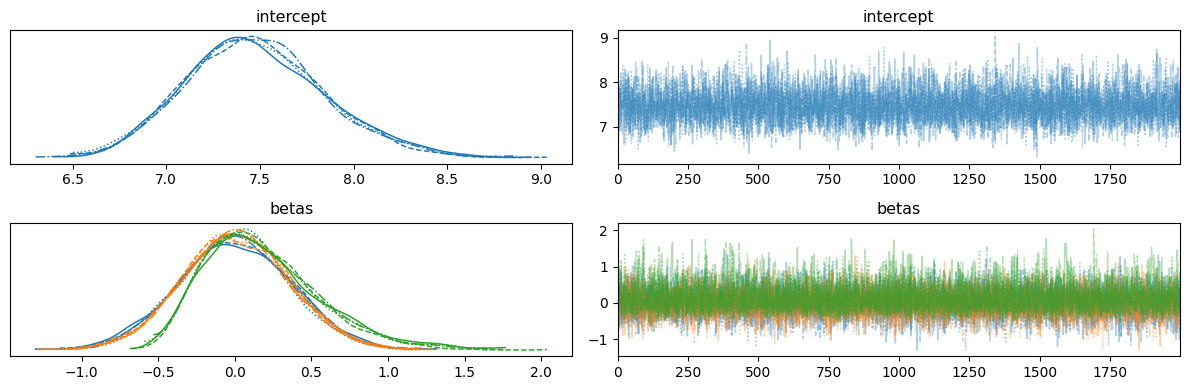

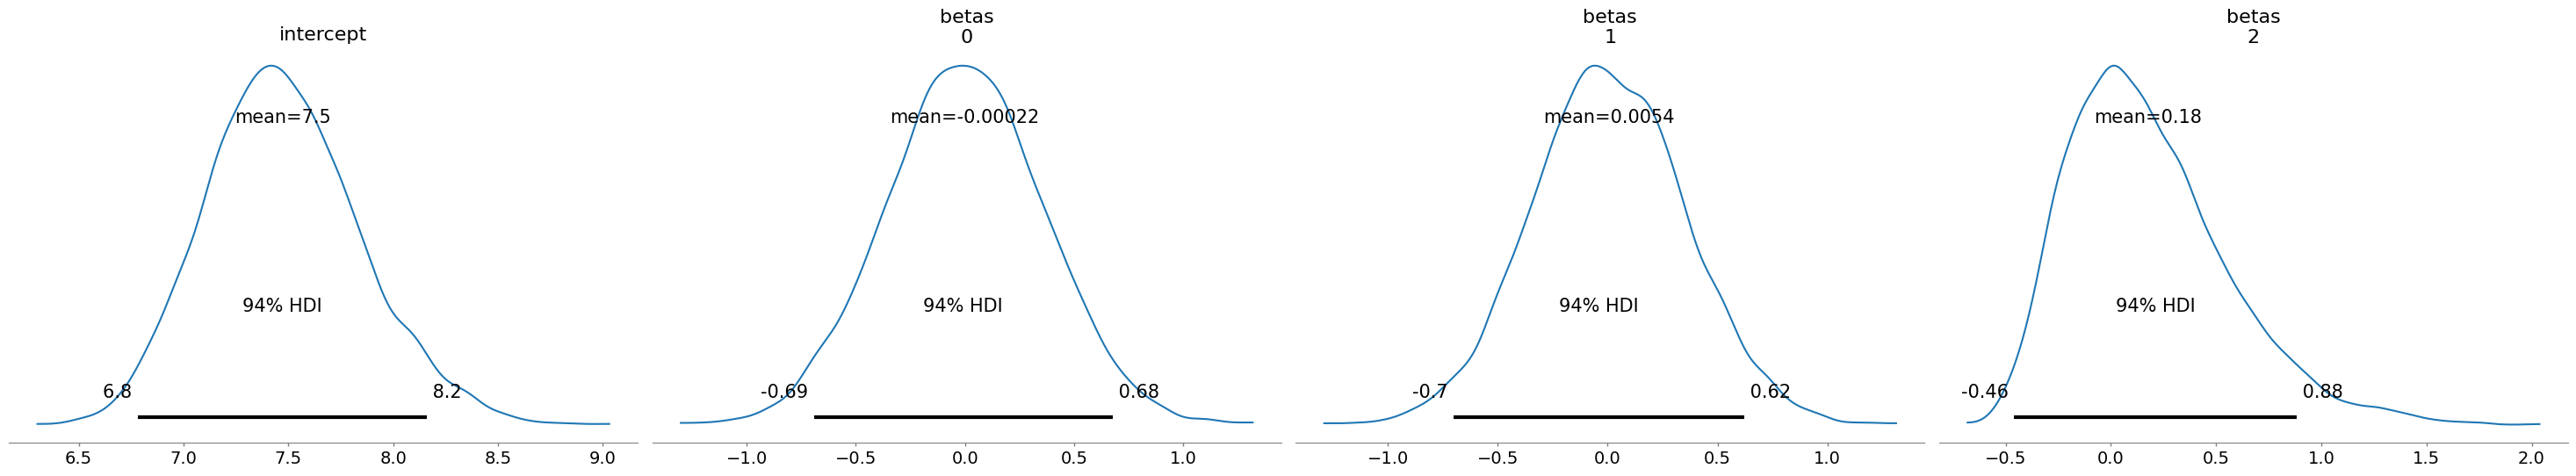

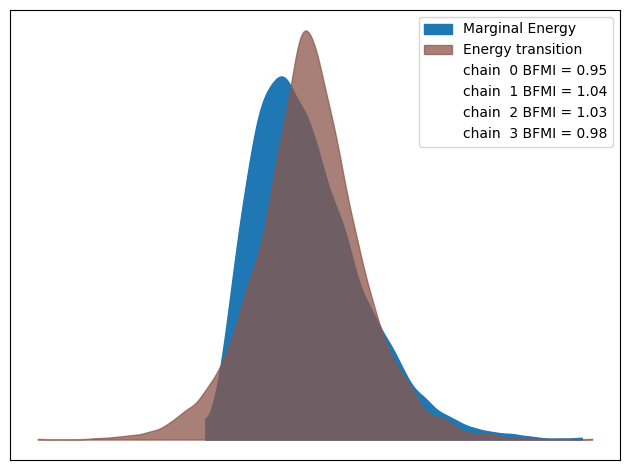

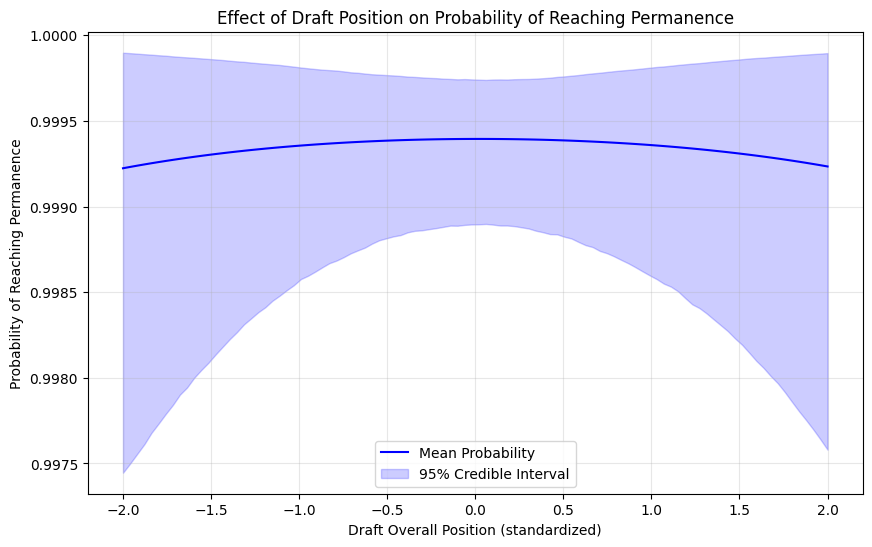

In [12]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load NHL dataset
df = pd.read_csv("nhl_data.csv", low_memory=False) 

# Create binary permanence variable
df['reached_permanence'] = (~df['time_to_permanence'].isna()).astype(int)

# Select relevant columns for modeling
columns = ['reached_permanence', 'draft_overall', 'BMI', 'draft_age_days']
df_clean = df[columns].dropna()

# Standardize the predictors
X_cols = ['draft_overall', 'BMI', 'draft_age_days']
scaler = StandardScaler()
X = scaler.fit_transform(df_clean[X_cols])

# Define target
y_permanence = df_clean['reached_permanence'].values

# Get number of predictors (p) and number of observations (n)
n, p = X.shape

# Create PyMC model for Bayesian logistic regression
with pm.Model() as logistic_model:
    # Priors for intercept and coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)
    
    # Linear combination of predictors
    linear_pred = intercept + pm.math.dot(X, betas)
    
    # Logistic link function
    p_reach_permanence = pm.math.invlogit(linear_pred)
    
    # Likelihood (Bernoulli)
    likelihood = pm.Bernoulli('likelihood', p=p_reach_permanence, observed=y_permanence)
    
    # Sample from the posterior - increase target_accept to address divergences
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)

# Trace summary
summary = az.summary(trace, round_to=3)

# Print summary
print("Model Summary:")
print(summary)

# Check convergence diagnostics
print("\nConvergence Diagnostics:")
print(f"R-hat values > 1.01: {(summary['r_hat'] > 1.01).sum()}")
print(f"Low effective sample size (ESS < 400): {(summary['ess_bulk'] < 400).sum()}")

# Plot trace
az.plot_trace(trace)
plt.tight_layout()
plt.savefig('trace_plot.png')

# Plot posterior distributions
az.plot_posterior(trace, var_names=['intercept', 'betas'])
plt.tight_layout()
plt.savefig('posterior_plot.png')

# Plot energy
az.plot_energy(trace)
plt.tight_layout()
plt.savefig('energy_plot.png')

# Calculate odds ratios
# Direct access approach for posterior samples
posterior = trace.posterior
chains = posterior.chain.shape[0]
draws = posterior.draw.shape[0]
total_samples = chains * draws

# Reshape beta samples to be (total_samples, p)
beta_samples = posterior.betas.values.reshape(total_samples, p)

# Calculate odds ratios (exponentiate the coefficients)
odds_ratios = np.exp(beta_samples)
or_mean = odds_ratios.mean(axis=0)

# Create DataFrame with odds ratios
data = []
for i in range(len(X_cols)):
    row = {
        'Predictor': X_cols[i],
        'Odds Ratio': float(or_mean[i]),
        'HDI 3%': float(np.percentile(odds_ratios[:, i], 3)),
        'HDI 97%': float(np.percentile(odds_ratios[:, i], 97))
    }
    data.append(row)

# Create the dataframe
or_df = pd.DataFrame(data)

print("\nOdds Ratios (for standardized predictors):")
print(or_df)

# Calculate predicted probabilities for different values of draft_overall
# Create a range of draft_overall values (from -2 to 2 standard deviations)
draft_range = np.linspace(-2, 2, 100)

# Create a prediction dataset with other variables at their means (0 after standardization)
X_pred = np.zeros((len(draft_range), p))
X_pred[:, 0] = draft_range  # Assuming draft_overall is the first column

# Direct access to posterior samples
intercept_samples = posterior.intercept.values.reshape(total_samples)

# Print information about the samples
print(f"Number of posterior samples: {total_samples}")
print(f"Intercept shape: {intercept_samples.shape}")
print(f"Beta shape: {beta_samples.shape}")

# Prepare arrays for storing predictions
probs = np.zeros((total_samples, len(draft_range)))

# Calculate probabilities for each posterior sample and each draft value
for i in range(total_samples):
    intercept_i = intercept_samples[i]
    beta_i = beta_samples[i]
    
    # Calculate predictions
    linear_pred = intercept_i + np.dot(X_pred, beta_i)
    probs[i] = 1 / (1 + np.exp(-linear_pred))

# Calculate mean and credible intervals
mean_probs = probs.mean(axis=0)
lower_ci = np.percentile(probs, 2.5, axis=0)
upper_ci = np.percentile(probs, 97.5, axis=0)

# Plot predicted probabilities
plt.figure(figsize=(10, 6))
plt.plot(draft_range, mean_probs, 'b-', label='Mean Probability')
plt.fill_between(draft_range, lower_ci, upper_ci, color='b', alpha=0.2, label='95% Credible Interval')
plt.xlabel('Draft Overall Position (standardized)')
plt.ylabel('Probability of Reaching Permanence')
plt.title('Effect of Draft Position on Probability of Reaching Permanence')
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('draft_effect_plot.png')

# Add check for divergences
divergences = trace.sample_stats.diverging.sum()
print(f"\nTotal number of divergences: {divergences}")
if divergences > 0:
    print("There were divergences in the sampling process.")
    print("Consider increasing target_accept further or reparameterizing the model.")

## Q2: perform Bayesian Multivariate Regression

- For a data set for which modeling multiple continuous outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics



In [37]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler

# Load NHL dataset (assuming file already exists)
df = pd.read_csv("nhl_data.csv", low_memory=False)

# Select target variables and potential predictors
target_vars = ['time_to_entry', 'time_to_permanence']
predictor_vars = ['draft_age_days', 'draft_overall', 'BMI', 
                  'player_dob_quartiles']

# Drop rows with missing values in the selected columns
selected_cols = target_vars + predictor_vars
df_clean = df[selected_cols].dropna()
print(f"Clean data shape: {df_clean.shape}")

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_clean, columns=[col for col in predictor_vars if df_clean[col].dtype == 'object'], 
                           drop_first=True)

# Separate predictors and targets
X_cols = [col for col in df_encoded.columns if col not in target_vars]
X = df_encoded[X_cols].values
y = df_encoded[target_vars].values

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"X shape: {X_scaled.shape}, y shape: {y.shape}")
print(f"Number of features (p): {X_scaled.shape[1]}")
print(f"Number of outcomes (m): {y.shape[1]}")
print(f"Number of observations (n): {X_scaled.shape[0]}")

Clean data shape: (10446, 6)
X shape: (10446, 6), y shape: (10446, 2)
Number of features (p): 6
Number of outcomes (m): 2
Number of observations (n): 10446


In [38]:
def run_multivariate_regression(X, y, n_samples=1000, n_chains=2, downsample_factor=1.0, seed=365):
    """
    Run Bayesian multivariate regression with PyMC
    
    Parameters:
    -----------
    X : array-like, shape (n, p)
        Predictor variables
    y : array-like, shape (n, m)
        Target variables
    n_samples : int
        Number of samples to draw
    n_chains : int
        Number of chains to run
    downsample_factor : float
        Fraction of data to use (0.0-1.0)
    seed : int
        Random seed
    
    Returns:
    --------
    idata : InferenceData
        Sampling results
    model : PyMC model
        The PyMC model
    X_subset : array
        The subset of X used
    y_subset : array
        The subset of y used
    """
    if downsample_factor < 1.0:
        # Downsample data
        np.random.seed(seed)
        n = X.shape[0]
        n_subset = int(n * downsample_factor)
        idx = np.random.choice(n, size=n_subset, replace=False)
        X_subset = X[idx]
        y_subset = y[idx]
    else:
        X_subset = X
        y_subset = y
    
    n, p = X_subset.shape
    _, m = y_subset.shape
    
    print(f"Running with n={n}, p={p}, m={m}")
    
    with pm.Model() as model:
        # LKJ prior for the covariance matrix
        packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                    sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                    compute_corr=False)
        L = pm.expand_packed_triangular(m, packed_L)
        
        # Regression coefficients
        betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))
        
        # Full covariance matrix from Cholesky factor
        Sigma = pm.Deterministic('Sigma', L.dot(L.T))
        
        # Multivariate Normal likelihood
        y_pred = pm.MvNormal('y', mu=X_subset @ betas, chol=L, observed=y_subset)
        
        # Sample from the posterior
        idata = pm.sample(n_samples, chains=n_chains, tune=500, 
                          return_inferencedata=True, random_seed=seed)
    
    return idata, model, X_subset, y_subset

Original dimensions: n=10446, p=6, m=2

Running with downsample factor: 0.1
Running with n=1044, p=6, m=2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [packed_L, betas]


Output()

/Users/yiru/Library/Python/3.12/lib/python/site-packages/pytensor/compile/function/types.py:992: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling time: 7.05 seconds
Mean r_hat: 1.0000, Max r_hat: 1.0000
Mean ESS: 2496.9, Min ESS: 2232.0


<Figure size 1200x800 with 0 Axes>

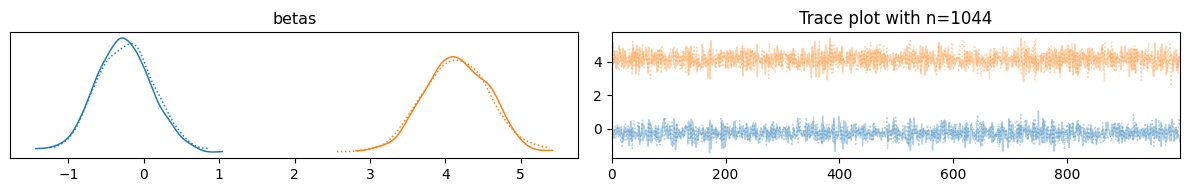


Running with downsample factor: 0.25
Running with n=2611, p=6, m=2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [packed_L, betas]


Output()

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling time: 10.08 seconds
Mean r_hat: 1.0000, Max r_hat: 1.0000
Mean ESS: 2450.0, Min ESS: 2293.0


<Figure size 1200x800 with 0 Axes>

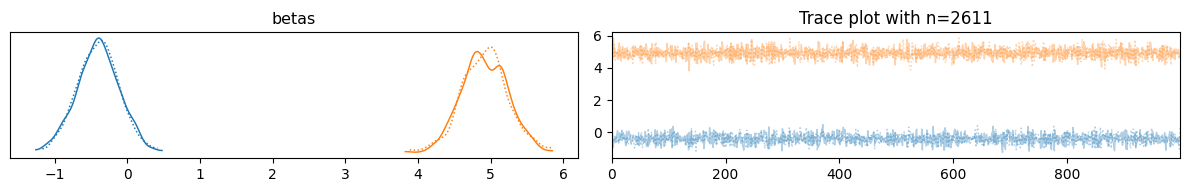


Running with downsample factor: 0.5
Running with n=5223, p=6, m=2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [packed_L, betas]


Output()

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling time: 14.88 seconds
Mean r_hat: 1.0000, Max r_hat: 1.0000
Mean ESS: 2433.3, Min ESS: 1863.0


<Figure size 1200x800 with 0 Axes>

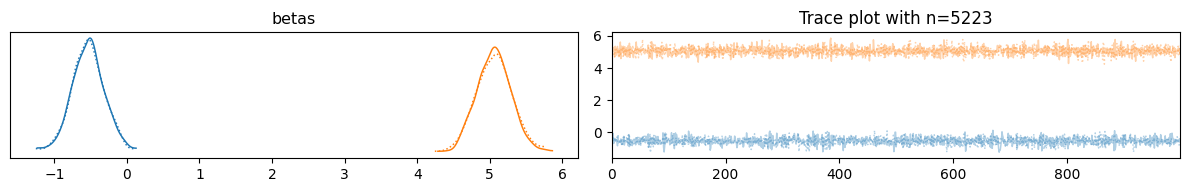


Running with downsample factor: 1.0
Running with n=10446, p=6, m=2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [packed_L, betas]


Output()

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling time: 25.43 seconds
Mean r_hat: 1.0000, Max r_hat: 1.0000
Mean ESS: 2132.2, Min ESS: 1653.0


<Figure size 1200x800 with 0 Axes>

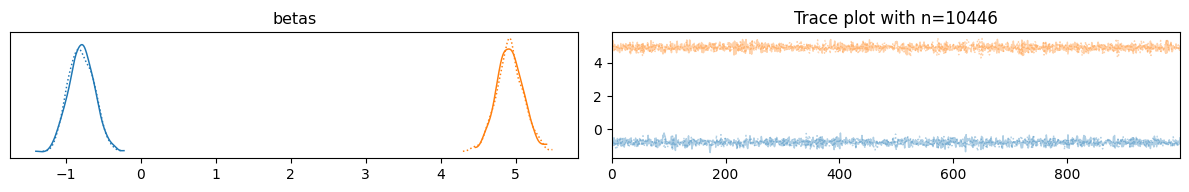

In [39]:
# Set original dimensions
n, p, m = X_scaled.shape[0], X_scaled.shape[1], y.shape[1]
print(f"Original dimensions: n={n}, p={p}, m={m}")

# Define downsample factors to try
downsample_factors = [0.1, 0.25, 0.5, 1.0]

# Storage for results
sampling_times = []
r_hat_values = []
ess_values = []

# Run models with different sample sizes
for factor in downsample_factors:
    try:
        print(f"\nRunning with downsample factor: {factor}")
        idata, model, X_subset, y_subset = run_multivariate_regression(
            X_scaled, y, n_samples=1000, downsample_factor=factor, seed=365)
        
        # Extract diagnostics
        summary = az.summary(idata, var_names=['betas'])
        
        # Record sampling time
        sampling_time = idata.posterior.attrs.get('sampling_time', None)
        sampling_times.append((factor, sampling_time))
        
        # Record r_hat (convergence diagnostic)
        r_hat_vals = summary['r_hat'].values
        r_hat_values.append((factor, np.mean(r_hat_vals), np.max(r_hat_vals)))
        
        # Record effective sample size
        ess_vals = summary['ess_bulk'].values
        ess_values.append((factor, np.mean(ess_vals), np.min(ess_vals)))
        
        print(f"Sampling time: {sampling_time:.2f} seconds")
        print(f"Mean r_hat: {np.mean(r_hat_vals):.4f}, Max r_hat: {np.max(r_hat_vals):.4f}")
        print(f"Mean ESS: {np.mean(ess_vals):.1f}, Min ESS: {np.min(ess_vals):.1f}")
        
        # Plot trace for a few betas
        plt.figure(figsize=(12, 8))
        az.plot_trace(idata, var_names=['betas'], coords={'betas_dim_0': [0, 1], 'betas_dim_1': [0]})
        plt.tight_layout()
        plt.title(f"Trace plot with n={int(n*factor)}")
        plt.show()
        
    except Exception as e:
        print(f"Error with factor {factor}: {e}")

Running with n=2611, p=6, m=2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Output()

Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 16 seconds.



Summary statistics for regression coefficients and covariance:
                mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]   -0.409   0.291   -0.970    0.122      0.003    0.002   10918.0   
betas[0, 1]    1.485   0.365    0.776    2.150      0.004    0.003   10853.0   
betas[1, 0]    4.924   0.321    4.330    5.551      0.003    0.002   10272.0   
betas[1, 1]    2.373   0.405    1.580    3.097      0.004    0.003   10095.0   
betas[2, 0]   -1.064   0.317   -1.645   -0.458      0.003    0.002   10558.0   
betas[2, 1]    0.843   0.404    0.092    1.603      0.004    0.003   10247.0   
betas[3, 0]   -0.064   0.330   -0.680    0.556      0.003    0.004    9811.0   
betas[3, 1]    0.094   0.417   -0.700    0.849      0.004    0.005   10737.0   
betas[4, 0]   -0.325   0.318   -0.934    0.247      0.003    0.003    9884.0   
betas[4, 1]    0.167   0.400   -0.615    0.888      0.004    0.004   10395.0   
betas[5, 0]   -0.613   0.332   -1.254   -0.018      0.00

<Figure size 1200x800 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

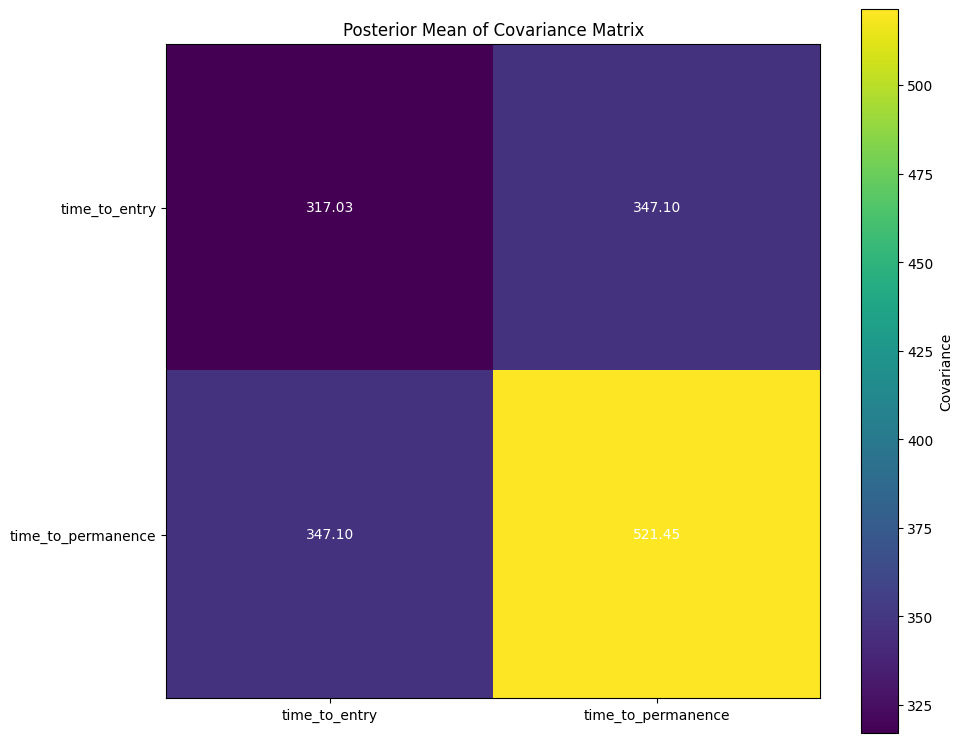

In [50]:
# Choose optimal downsample factor based on exploration
optimal_factor = 0.25  # determined from the exploration results

# Run the final analysis
final_idata, final_model, X_final, y_final = run_multivariate_regression(
    X_scaled, y, n_samples=2000, n_chains=4, downsample_factor=optimal_factor, seed=365)

# Comprehensive diagnostics
summary = az.summary(final_idata, var_names=['betas', 'Sigma'])
print("\nSummary statistics for regression coefficients and covariance:")
print(summary)

# Plot diagnostics
plt.figure(figsize=(12, 8))
az.plot_trace(final_idata, var_names=['betas'], coords={'betas_dim_0': [0, 1, 2], 'betas_dim_1': range(m)})
plt.tight_layout()
plt.savefig('trace_plot.png')
plt.close()

# Plot energy
plt.figure(figsize=(10, 6))
az.plot_energy(final_idata)
plt.tight_layout()
plt.savefig('energy_plot.png')
plt.close()

# Plot forest plot for regression coefficients
plt.figure(figsize=(12, 10))
az.plot_forest(final_idata, var_names=['betas'], coords={'betas_dim_0': range(min(5, p))}, 
              combined=True, hdi_prob=0.95)
plt.tight_layout()
plt.savefig('forest_plot.png')
plt.close()

# Visualize the covariance matrix
plt.figure(figsize=(10, 8))
Sigma_post_mean = final_idata.posterior['Sigma'].mean(axis=(0,1)).values
plt.imshow(Sigma_post_mean, cmap='viridis')
plt.colorbar(label='Covariance')
plt.title('Posterior Mean of Covariance Matrix')
plt.xticks(range(m), target_vars)
plt.yticks(range(m), target_vars)
for i in range(m):
    for j in range(m):
        plt.text(j, i, f'{Sigma_post_mean[i, j]:.2f}', 
                 ha='center', va='center', color='white')
plt.tight_layout()
plt.savefig('covariance_matrix.png')
plt.show()

# Analyze posterior predictive distribution
n_posterior_samples = 500
random_indices = np.random.choice(len(final_idata.posterior.chain) * 
                                 len(final_idata.posterior.draw), n_posterior_samples)

beta_samples = final_idata.posterior.betas.values.reshape(-1, p, m)[random_indices]
sigma_samples = final_idata.posterior.Sigma.values.reshape(-1, m, m)[random_indices]

# Create posterior predictive samples for a few observations
test_indices = np.random.choice(X_final.shape[0], 5)
X_test = X_final[test_indices]
y_test = y_final[test_indices]

# Generate predictions
y_pred_samples = np.zeros((n_posterior_samples, len(test_indices), m))
for i, (beta, sigma) in enumerate(zip(beta_samples, sigma_samples)):
    # Calculate predicted means for each test observation
    means = X_test @ beta  # This should be shape (n_test, m)
    
    # Generate multivariate normal samples for each test observation
    for j in range(len(test_indices)):
        y_pred_samples[i, j, :] = np.random.multivariate_normal(mean=means[j], cov=sigma)

In [51]:
# Report key findings
print("\n=== KEY FINDINGS ===")
print(f"Dataset size: n={X_final.shape[0]}, p={p}, m={m}")
print("\nPosterior means of regression coefficients:")
beta_means = final_idata.posterior.betas.mean(axis=(0,1)).values
for i, var_name in enumerate(X_cols):
    coeffs = beta_means[i]
    print(f"{var_name}: {', '.join([f'{c:.4f}' for c in coeffs])}")

print("\nCovariance between outcomes:")
for i in range(m):
    for j in range(i+1, m):
        print(f"{target_vars[i]} and {target_vars[j]}: {Sigma_post_mean[i, j]:.4f}")

print("\nMCMC diagnostics:")
print(f"Mean r_hat: {summary['r_hat'].mean():.4f}, Max r_hat: {summary['r_hat'].max():.4f}")
print(f"Mean ESS (bulk): {summary['ess_bulk'].mean():.1f}, Min ESS: {summary['ess_bulk'].min():.1f}")


=== KEY FINDINGS ===
Dataset size: n=2611, p=6, m=2

Posterior means of regression coefficients:
draft_age_days: -0.4093, 1.4849
draft_overall: 4.9240, 2.3732
BMI: -1.0641, 0.8427
player_dob_quartiles_Q2: -0.0641, 0.0937
player_dob_quartiles_Q3: -0.3246, 0.1672
player_dob_quartiles_Q4: -0.6133, -0.5938

Covariance between outcomes:
time_to_entry and time_to_permanence: 347.1007

MCMC diagnostics:
Mean r_hat: 1.0000, Max r_hat: 1.0000
Mean ESS (bulk): 10549.8, Min ESS: 9478.0


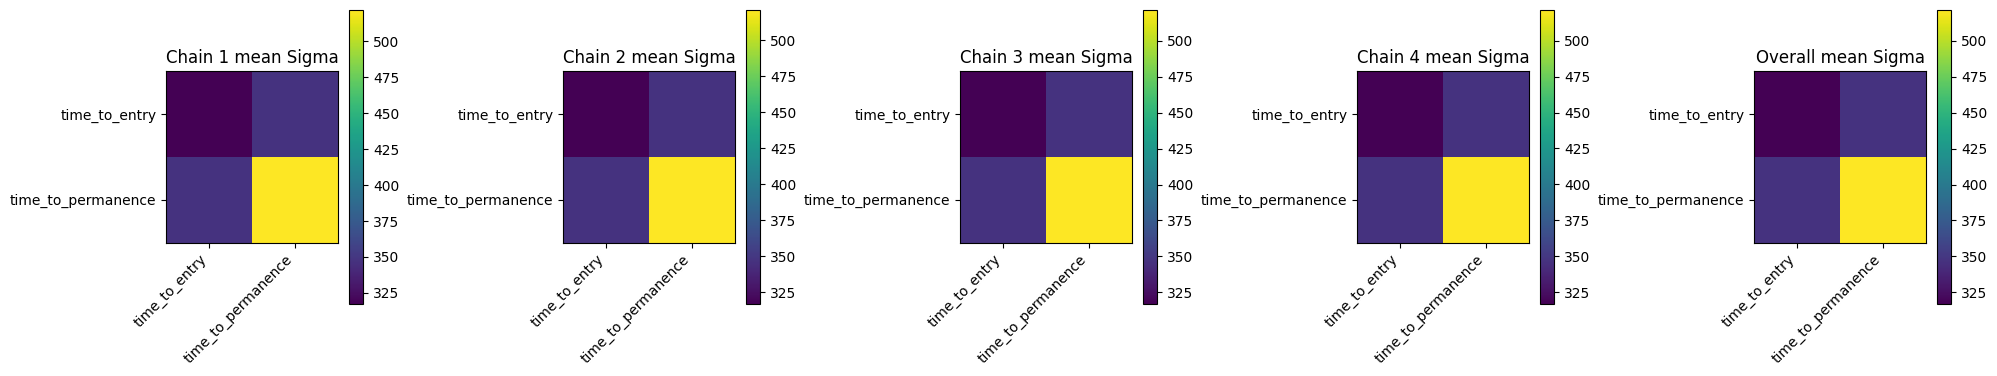

In [52]:
# Extract the posterior samples for Sigma
Sigma_samples = final_idata.posterior['Sigma'].values  # shape (chains, draws, m, m)
n_chains = Sigma_samples.shape[0]

fig, ax = plt.subplots(1, n_chains + 1, figsize=(4*(n_chains + 1), 4))

# Overall posterior mean across all chains and draws
Sigma_post_mean = Sigma_samples.mean(axis=(0,1))
im = ax[-1].imshow(Sigma_post_mean, cmap='viridis')
ax[-1].set_title("Overall mean Sigma")
fig.colorbar(im, ax=ax[-1])

# Plot chain-specific posterior mean Sigmas
for chain in range(n_chains):
    chain_mean_Sigma = Sigma_samples[chain].mean(axis=0)
    im = ax[chain].imshow(chain_mean_Sigma, cmap='viridis')
    ax[chain].set_title(f"Chain {chain+1} mean Sigma")
    fig.colorbar(im, ax=ax[chain])

# Label axes with target variable names
for axis in ax:
    axis.set_xticks(np.arange(len(target_vars)))
    axis.set_yticks(np.arange(len(target_vars)))
    axis.set_xticklabels(target_vars, rotation=45, ha='right')
    axis.set_yticklabels(target_vars)

plt.tight_layout()
plt.savefig('Sigma_chain_means.png')
plt.show()

## Q3: perform Bayesian Multivariate Classification

- For a data set for which modeling multiple binary outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Use latent `z = pm.MvNormal('z', mu=X@betas, chol=L)` as discussed in the "Generalized Linear Models (GLM)" section of the previous weeks lecture notes

> This provides normally distributed latent variables connected to the observed binary outcomes on which a latent covariance dependency structure may be modelled and estimated on the basis of imputing the unobserved latent variables based on their connection with the observed binary outcome variables.

- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

Binary variables created.
Clean data shape: (498, 5)
Predictors standardized.
Targets defined.
Dimensions set: n=498, p=3, m=2
Starting model definition.
Covariance structure defined.
Regression coefficients defined.
Latent variables defined.
Observed binary outcomes defined.
Starting sampling.


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_packed, betas, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 161 seconds.
There were 557 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling completed.


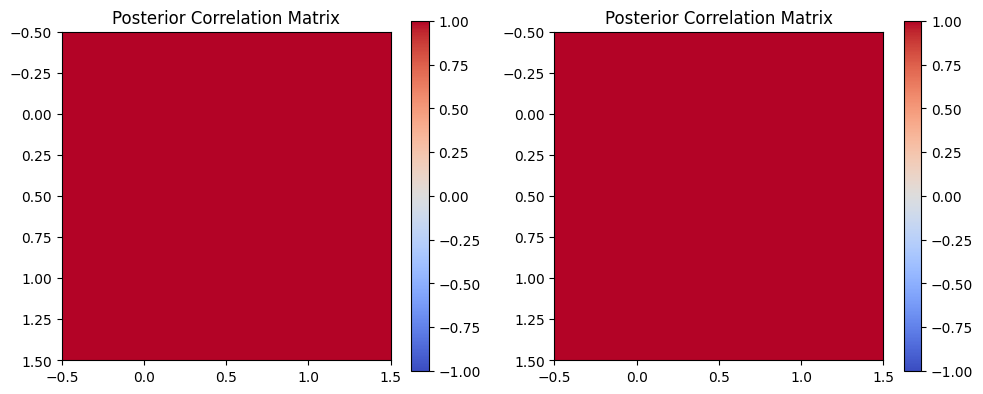

Plotting trace and summary.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",-0.027,0.505,-0.908,0.989,0.015,0.013,1188.0,2050.0,1.01
"betas[0, 1]",-0.008,0.512,-1.052,0.881,0.012,0.010,1844.0,1927.0,1.01
"betas[1, 0]",0.007,0.486,-0.895,0.930,0.014,0.010,1152.0,2362.0,1.01
"betas[1, 1]",-0.006,0.503,-0.943,0.976,0.011,0.011,1942.0,2527.0,1.01
"betas[2, 0]",0.048,0.526,-0.944,0.939,0.026,0.018,431.0,1323.0,1.01
"betas[2, 1]",0.033,0.519,-0.967,0.989,0.012,0.013,1782.0,2205.0,1.01
"Sigma[0, 0]",147.678,63.405,52.052,266.598,9.218,6.559,37.0,70.0,1.11
"Sigma[0, 1]",144.461,46.610,69.307,234.181,7.416,5.283,40.0,89.0,1.10
"Sigma[1, 0]",144.461,46.610,69.307,234.181,7.416,5.283,40.0,89.0,1.10
"Sigma[1, 1]",151.823,64.547,51.432,278.949,7.572,5.376,75.0,118.0,1.05


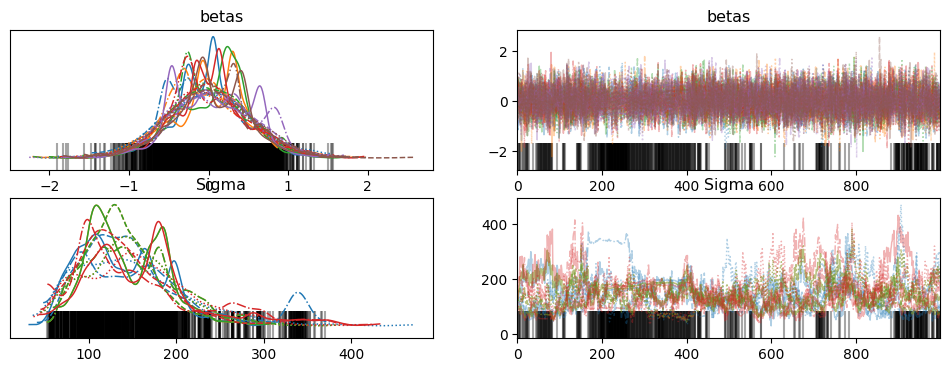

In [65]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pytensor.tensor as pt

# Load and preprocess NHL data
df_full = pd.read_csv("nhl_data.csv", low_memory=False)
df = df.sample(n=500, random_state=42)

# Create binary permanence variables
df['reached_entry'] = (~df['time_to_entry'].isna()).astype(int)
df['reached_permanence'] = (~df['time_to_permanence'].isna()).astype(int)
print("Binary variables created.")

# Select and clean relevant columns
columns = ['reached_permanence', 'reached_entry', 'draft_overall', 'BMI', 'draft_age_days']
df_clean = df[columns].dropna()
print(f"Clean data shape: {df_clean.shape}")

# Standardize predictors
scaler = StandardScaler()
X = scaler.fit_transform(df_clean[['draft_overall', 'BMI', 'draft_age_days']])
print("Predictors standardized.")

# Define targets
y_binary = df_clean[['reached_permanence', 'reached_entry']].values
print("Targets defined.")

# Define dimensions
n, p = X.shape
m = y_binary.shape[1]
print(f"Dimensions set: n={n}, p={p}, m={m}")

# Bayesian multivariate probit model
with pm.Model() as GLM:
    print("Starting model definition.")
    # Latent covariance structure (Cholesky decomposition)
    # Latent covariance structure (Cholesky decomposition)
    L, corr_matrix_initial, stds = pm.LKJCholeskyCov(
        "chol_packed", n=m, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    
    Sigma = pm.Deterministic("Sigma", L @ L.T)
    sigma_diag = pm.math.sqrt(pt.diag(Sigma))
    
    corr_matrix = pm.Deterministic(
        "R_corr",
        Sigma / sigma_diag[:, None] / sigma_diag[None, :]
    )
    print("Covariance structure defined.")

    # Regression coefficients
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))
    print("Regression coefficients defined.")

    # Latent variable model
    z = pm.MvNormal('z', mu=pm.math.dot(X, betas), chol=L, shape=(n, m))
    print("Latent variables defined.")

    # Observed binary outcomes via inverse probit
    y = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=y_binary)
    print("Observed binary outcomes defined.")

    # Sampling
    print("Starting sampling.")
    idata = pm.sample(1000, tune=1000, cores=4, random_seed=42)
    print("Sampling completed.")

# Visualization of estimated correlation matrices
fig, axes = plt.subplots(1, m, figsize=(5 * m, 4))
for i in range(m):
    mean_corr = idata.posterior['R_corr'].mean(dim=('chain', 'draw')).values
    im = axes[i].imshow(mean_corr, cmap='coolwarm', vmin=-1, vmax=1)
    axes[i].set_title(f"Posterior Correlation Matrix")
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

# MCMC diagnostics
print("Plotting trace and summary.")
az.plot_trace(idata, var_names=['betas', 'Sigma'])
az.summary(idata, var_names=['betas', 'Sigma'])